<a href="https://colab.research.google.com/github/limperstickhelp23/Credit_Fraud_Detection/blob/main/NNModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN


In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Only use this code block if you are using Google Colab.
# If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
from google.colab import files

## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file.
## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
uploaded = files.upload()

Saving fraud_test.csv to fraud_test.csv


In [12]:
data = pd.read_csv('fraud_test.csv')
y = data["is_fraud"]
X = data.drop(['is_fraud'],axis=1)


#Modify columns
X_used = X.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat', 'merch_long'],axis = 1)
from datetime import datetime

X_used['dob'] = pd.to_datetime(X_used['dob'], dayfirst = True)
current_date = datetime.now()
X_used['Age'] = (current_date - X_used['dob']).dt.days // 365
X_used = X_used.drop('dob', axis = 1)

X_used = pd.get_dummies(X_used, columns = ['category', 'gender'],dtype = int, drop_first = True)



In [5]:
used_data = X_used.copy()
used_data['is_fraud'] = y

features = used_data.select_dtypes(np.object_).columns
cat_features = []
for feature in features:
    used_data[feature] = used_data[feature].astype('category')
    cat_features.append(feature)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(used_data.drop('is_fraud', axis = 1),
                                                    used_data['is_fraud'],
                                                    stratify = used_data['is_fraud'],
                                                    test_size = 0.25)

train_data = X_train.copy()
train_data['is_fraud'] = y_train

In [14]:
cols_encoder = cat_features

encoder = ce.BinaryEncoder(cols=cols_encoder)

tra_encoder = encoder.fit_transform(X_train[cols_encoder])
test_encode = encoder.transform(X_test[cols_encoder])

X_train = X_train.drop(columns=cols_encoder).join(tra_encoder)

X_test = X_test.drop(columns=cols_encoder).join(test_encode)

In [15]:
#Doing oversampling to help with the imbalanced
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy = 'auto')

X_train, y_train = smote.fit_resample(X_train, y_train)


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_rovs = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Using code from kaggle on using nueral networks to help with classifcation: https://www.kaggle.com/code/guptanuj890/creditcardfraudtransaction-with-98-f-score

This code basically uses nuerall netowrks with an adam optimizer and 3 hidden. layers. Most of them are linear and the output is a sigmoid acitvatation function

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

In [18]:
tf.random.set_seed(42)
nn_model = Sequential([
    Dense(128, input_dim=x_rovs.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [19]:
nn_model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9088      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19457 (76.00 KB)
Trainable params: 19457 (76.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
fitted_model = nn_model.fit(x_rovs, y_train, epochs = 15, validation_split = 0.3, callbacks = [early_stopping])

Epoch 1/15
18165/18165 [==============================] - 58s 3ms/step - loss: 0.0441 - accuracy: 0.9848 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 2/15
18165/18165 [==============================] - 49s 3ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0020 - val_accuracy: 0.9998
Epoch 3/15
18165/18165 [==============================] - 49s 3ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0186 - val_accuracy: 0.9939
Epoch 4/15
18165/18165 [==============================] - 50s 3ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9986
Epoch 5/15
18165/18165 [==============================] - 48s 3ms/step - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.0089 - val_accuracy: 0.9978
Epoch 6/15
18165/18165 [==============================] - 48s 3ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0028 - val_accuracy: 0.9989
Epoch 7/15
18165/18165 [==============================] - 49s 3ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0

In [21]:
nn_model.evaluate(X_test, y_test)

4342/4342 [==============================] - 7s 2ms/step - loss: 0.0137 - accuracy: 0.9968


[0.013739367015659809, 0.9968185424804688]

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_fscore_support,auc, roc_curve,precision_recall_curve

In [23]:
y_pred_ovs = nn_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_ovs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_ovs)
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

4342/4342 [==============================] - 7s 2ms/step
roc_auc: 0.9876878262775174 pr_recall: 0.611698955584542


In [24]:
threshold = 0.5
y_pred = (y_pred_ovs > threshold).astype(int)

<function matplotlib.pyplot.show(close=None, block=None)>

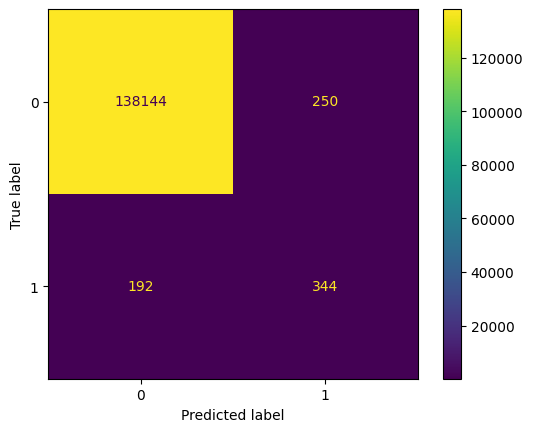

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
confusion_matrix(y_test,y_pred)

from sklearn.metrics import ConfusionMatrixDisplay,PrecisionRecallDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show

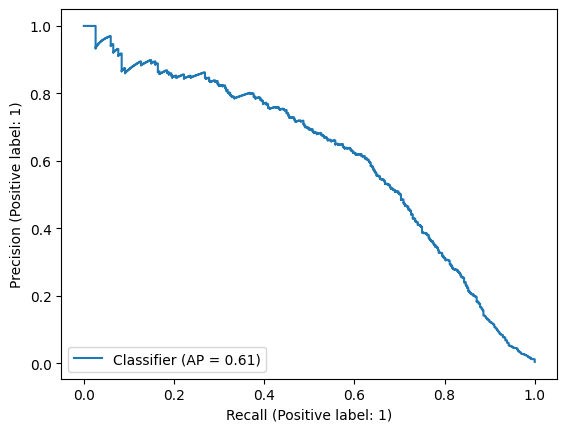

In [26]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred_ovs)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138394
           1       0.58      0.64      0.61       536

    accuracy                           1.00    138930
   macro avg       0.79      0.82      0.80    138930
weighted avg       1.00      1.00      1.00    138930

